In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pymc
import pytensor.tensor as pt
from pytensor.graph.op import Op
from pytensor.graph.basic import Apply
from tesseract_core import Tesseract


In [2]:
def numpy_to_model_input(arr):
    """Convert a numpy array to a dictionary of inputs."""
    return {
        "ne": arr[0],
        "Te": arr[1],
        "amp1": arr[2],
        "amp2": arr[3],
        "lam": arr[4],
    }

true_parameter = {
            "ne": 0.19,
            "Te": 0.8,
            "amp1": 2.08,
            "amp2": 1.42,
            "lam": 526.68,
            }

with Tesseract.from_image("tsadar-tesseract") as tesseract:
    output_true = tesseract.apply(true_parameter)["electron_spectrum"]

# Parameter inference via optimization (sanity check)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 207
         Function evaluations: 349


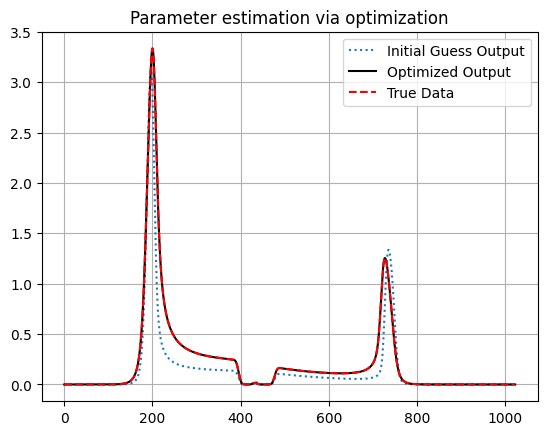

<Figure size 640x480 with 0 Axes>

In [3]:
with Tesseract.from_image("tsadar-tesseract") as tesseract:
    def objective_function(inputs):
        output = tesseract.apply(numpy_to_model_input(inputs))["electron_spectrum"]
        return np.sum((output - output_true) ** 2)

    initial_guess = np.array([0.5, 0.4, 1.6, 2.0, 300.0])  # Initial guess for the parameters
    output_initial_guess = tesseract.apply(numpy_to_model_input(initial_guess))["electron_spectrum"]

    result = scipy.optimize.minimize(
        objective_function,
        initial_guess,
        method='Nelder-Mead',
        options={'disp': True}
    )
    optimized_params = result.x

    output_optimized = tesseract.apply(numpy_to_model_input(optimized_params))["electron_spectrum"]



plt.title("Parameter estimation via optimization")
plt.grid()
plt.plot(np.arange(len(output_initial_guess)), output_initial_guess, label='Initial Guess Output', linestyle=':')
plt.plot(np.arange(len(output_optimized)), output_optimized, label='Optimized Output', color='black')
plt.plot(np.arange(len(output_true)), output_true, label='True Data', linestyle='--', color='red')
plt.legend()
plt.show()
plt.savefig("electron_spectrum.png")

# Bayesian parameter inference via sampling (Markov chain Monte Carlo)

In [4]:
with Tesseract.from_image("tsadar-tesseract") as tesseract:

    # Wrap forward model in a Pytensor Op for use in PyMC
    class ForwardOp(Op):
        itypes = [pt.dvector]
        otypes = [pt.dvector]

        def perform(self, node, inputs, outputs):
            x = inputs[0]
            outputs[0][0] = tesseract.apply(numpy_to_model_input(x))["electron_spectrum"]

        def infer_shape(self, fgraph, input_shapes):
            # Return the expected output shape - should match electron_spectrum shape
            return [(output_true.shape[0],)]

    # Define and sample the Bayesian posterior
    with pymc.Model() as model:
        # Define priors for the parameters
        ne = pymc.Normal("ne", mu=0.5, sigma=0.5)
        Te = pymc.Normal("Te", mu=0.4, sigma=0.4)
        amp1 = pymc.Normal("amp1", mu=1.6, sigma=0.5)
        amp2 = pymc.Normal("amp2", mu=2.0, sigma=0.5)
        lam = pymc.Normal("lam", mu=300.0, sigma=200.0)

        params = pt.stack([ne, Te, amp1, amp2, lam])

        # Define posterior from likelihood and priors
        posterior = pymc.Normal("likelihood", mu=ForwardOp()(params), sigma=0.5, observed=output_true)
        trace = pymc.sample(
            500,
            tune=100,
            step=[
                pymc.Metropolis(vars=[ne], scaling=0.1),
                pymc.Metropolis(vars=[Te], scaling=0.1),
                pymc.Metropolis(vars=[amp1], scaling=0.5),
                pymc.Metropolis(vars=[amp2], scaling=0.5),
                pymc.Metropolis(vars=[lam], scaling=200.0),
            ],
            cores=1,
            return_inferencedata=True
        )

/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/shape.py:156: UserWarning: Failed to infer_shape from Op ForwardOp.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(5)),)]
Exception encountered during infer_shape: <class 'TypeError'>
Exception message: ForwardOp.infer_shape() takes 3 positional arguments but 4 were given
Traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/shape.py", line 132, in get_node_infer_shape
    o_shapes = shape_infer(
               ^^^^^^^^^^^^
TypeError: ForwardOp.infer_shape() takes 3 positional arguments but 4 were given

  warn(msg)
/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/shape.py:156: UserWarning: Failed to infer_shape from Op ForwardOp.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(5)),)]
Exception encountered during infer_shape: <class 'TypeError'>
Exception message: ForwardOp.infer_shape() takes

Output()

Sampling 2 chains for 100 tune and 500 draw iterations (200 + 1_000 draws total) took 227 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


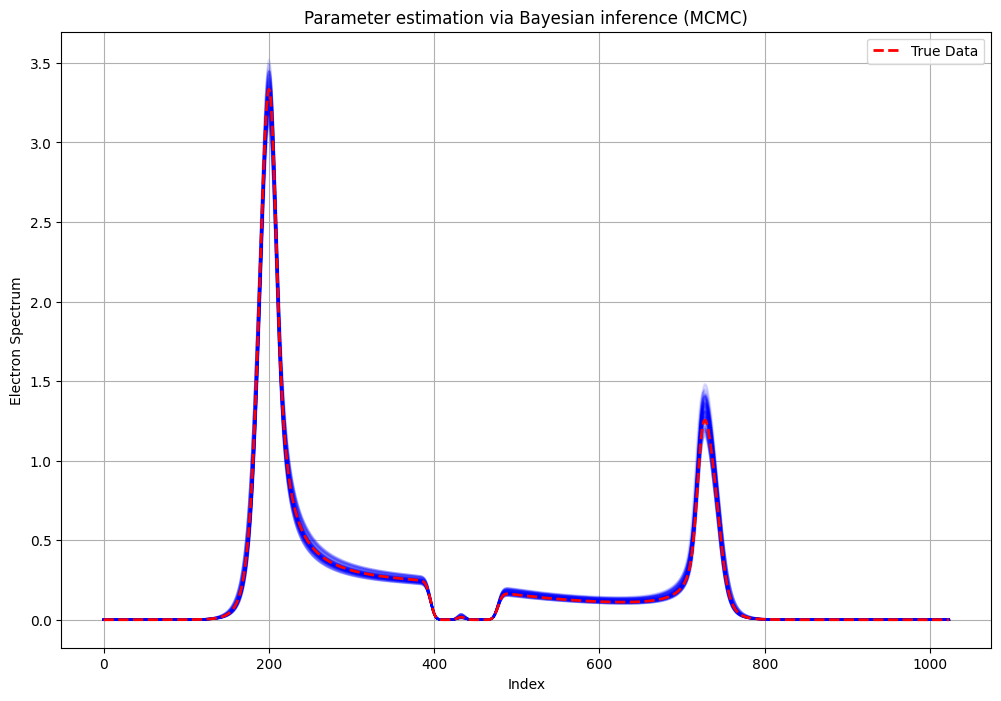

In [5]:
import arviz as az

plt.figure(figsize=(12, 8))
plt.title("Parameter estimation via Bayesian inference (MCMC)")
plt.grid()

posterior_samples = trace.posterior
n_samples_to_plot = 100

with Tesseract.from_image("tsadar-tesseract") as tesseract:
    for i in range(n_samples_to_plot):
        # Get a random sample
        sample_idx = np.random.randint(0, len(posterior_samples.chain) * len(posterior_samples.draw))
        chain_idx = sample_idx // len(posterior_samples.draw)
        draw_idx = sample_idx % len(posterior_samples.draw)

        sample_params = np.array([
            posterior_samples.ne.isel(chain=chain_idx, draw=draw_idx).values,
            posterior_samples.Te.isel(chain=chain_idx, draw=draw_idx).values,
            posterior_samples.amp1.isel(chain=chain_idx, draw=draw_idx).values,
            posterior_samples.amp2.isel(chain=chain_idx, draw=draw_idx).values,
            posterior_samples.lam.isel(chain=chain_idx, draw=draw_idx).values,
        ])

        sample_output = tesseract.apply(numpy_to_model_input(sample_params))["electron_spectrum"]
        plt.plot(np.arange(len(sample_output)), sample_output, alpha=0.1, color='blue')

# Plot true data on top
plt.plot(np.arange(len(output_true)), output_true, label='True Data', color='red', linewidth=2, linestyle='--')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Electron Spectrum')
plt.savefig("mcmc_results.png")
plt.show()


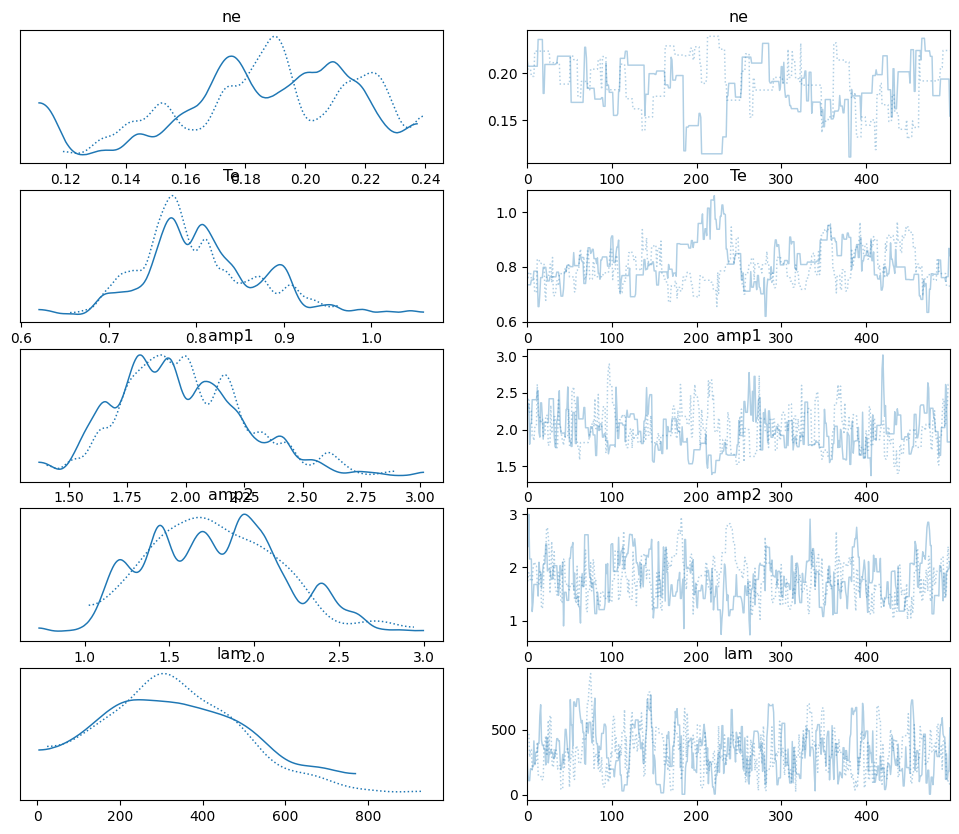

In [6]:
# Plot parameter samples

az.plot_trace(trace)
plt.savefig("trace_plot.png")
plt.show()

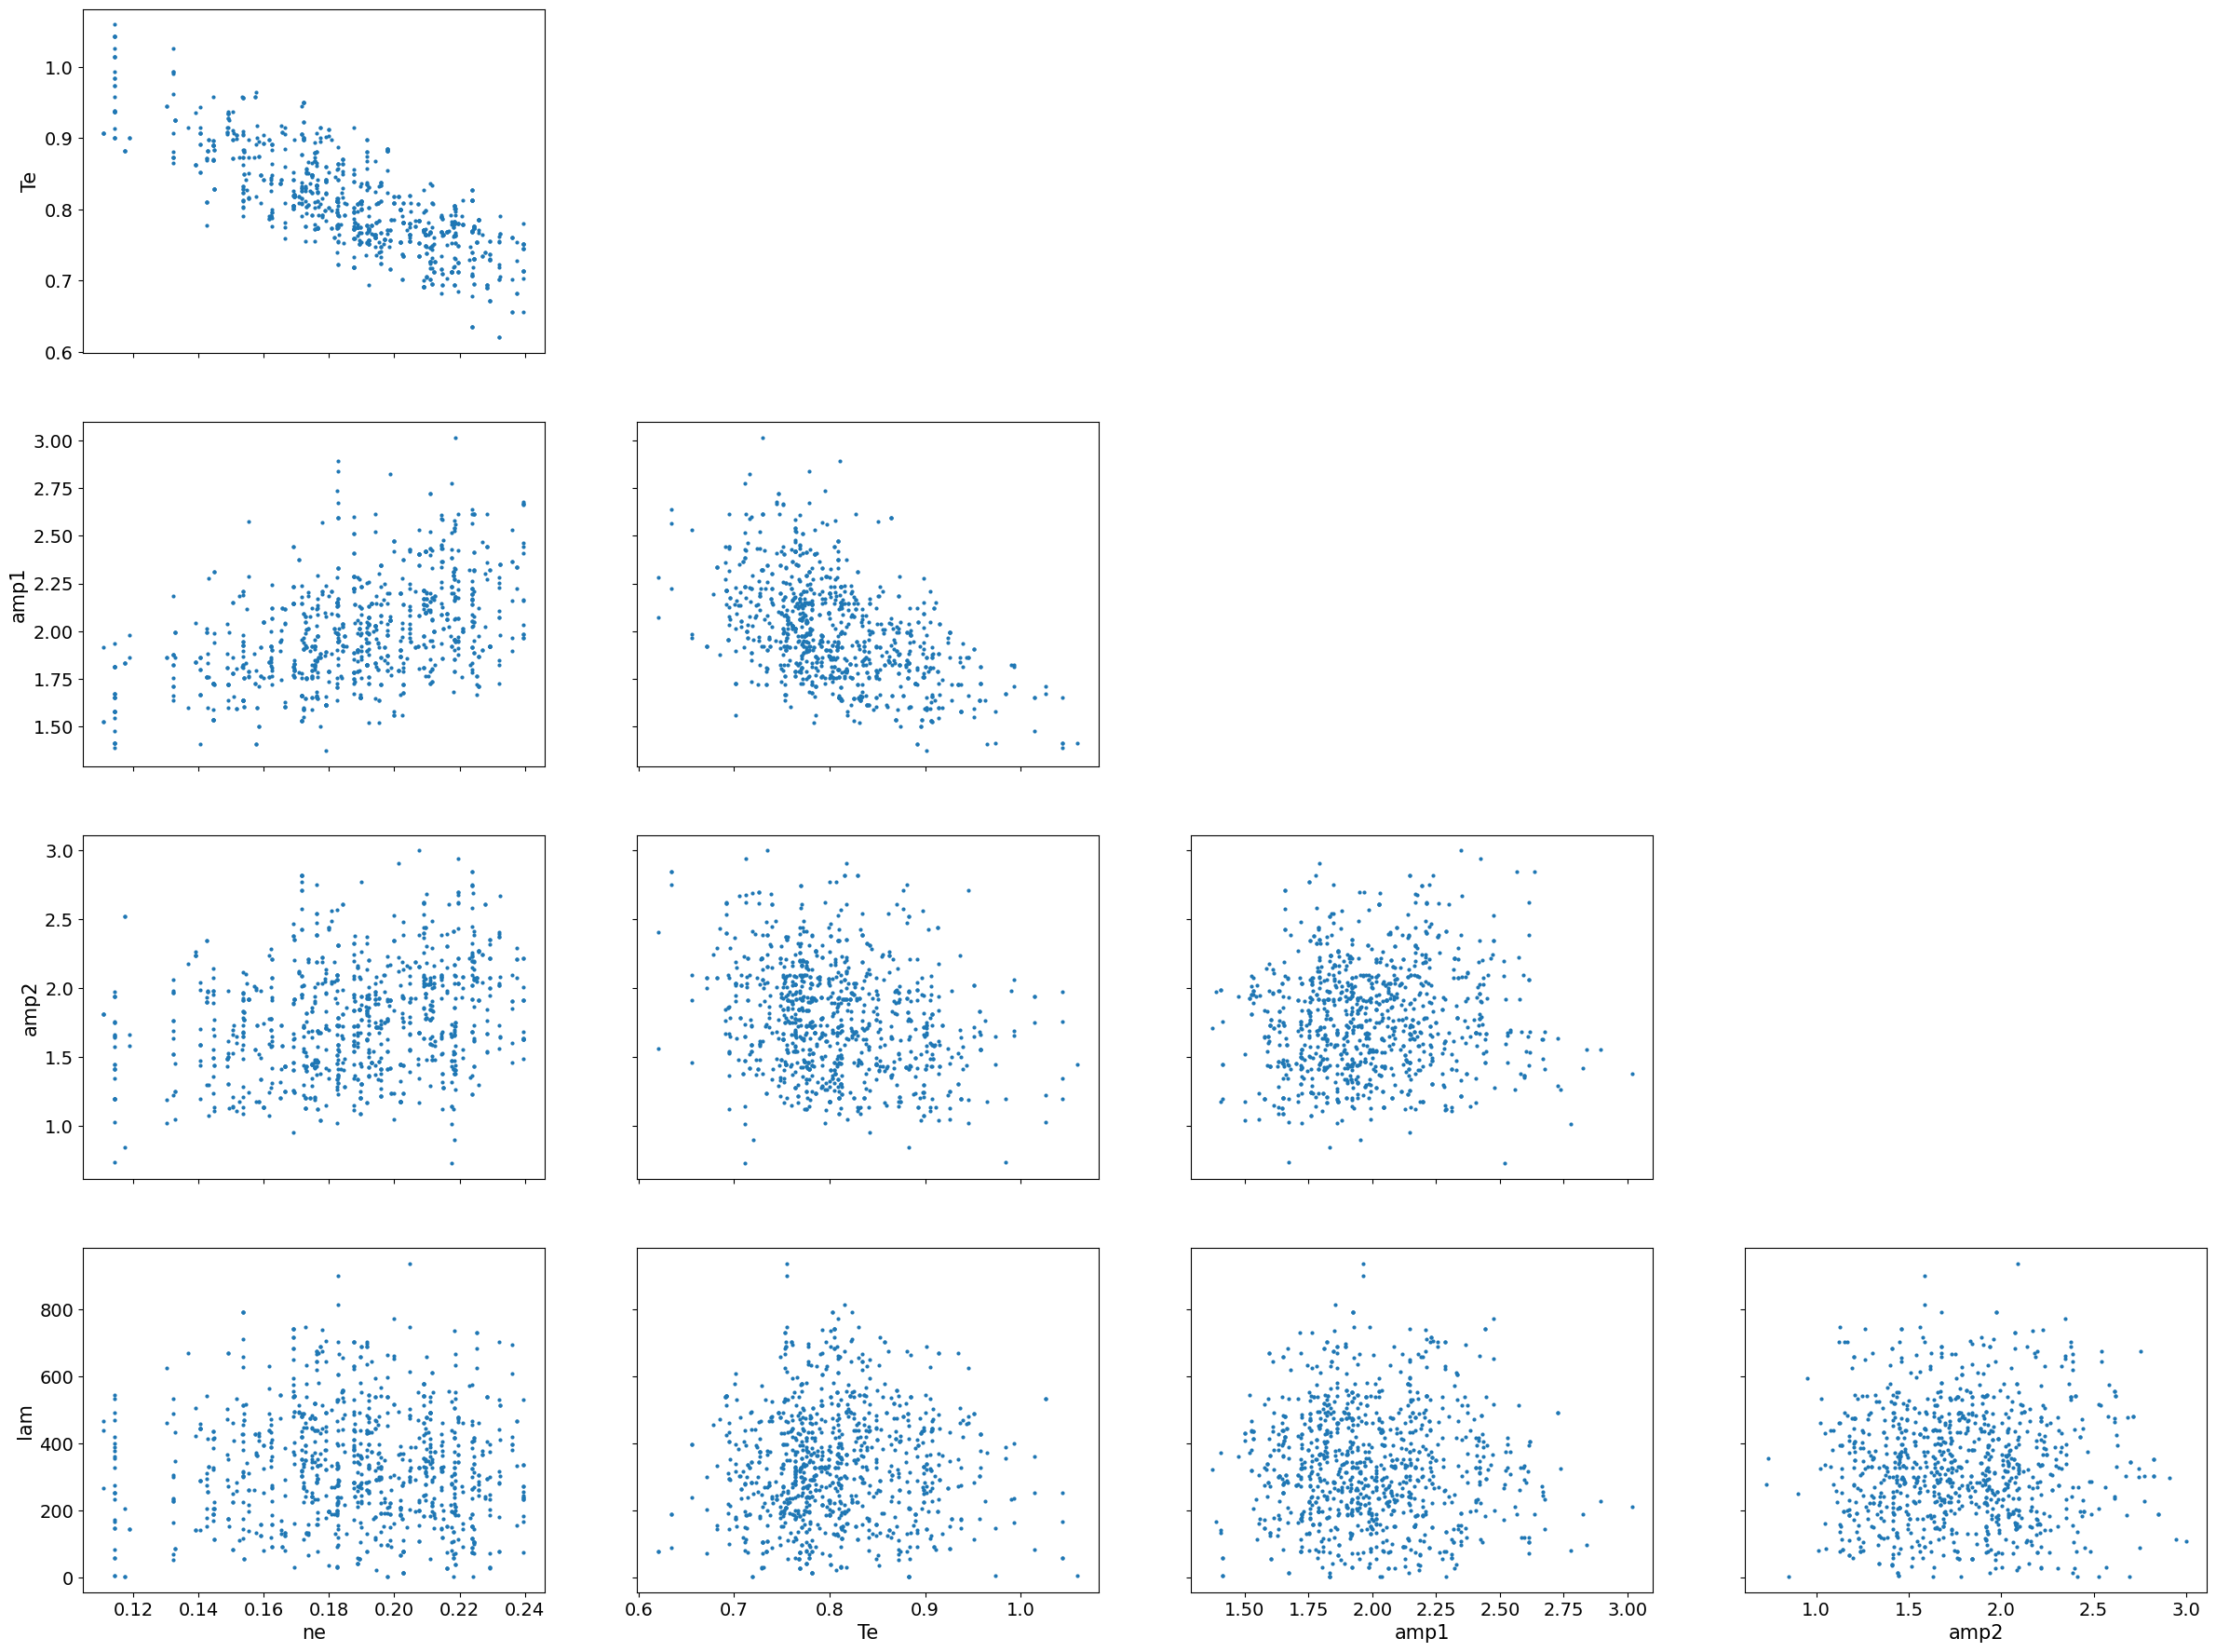

In [7]:
az.plot_pair(trace, var_names=["ne", "Te", "amp1", "amp2", "lam"])
plt.savefig("pair_plot.png")
plt.show()

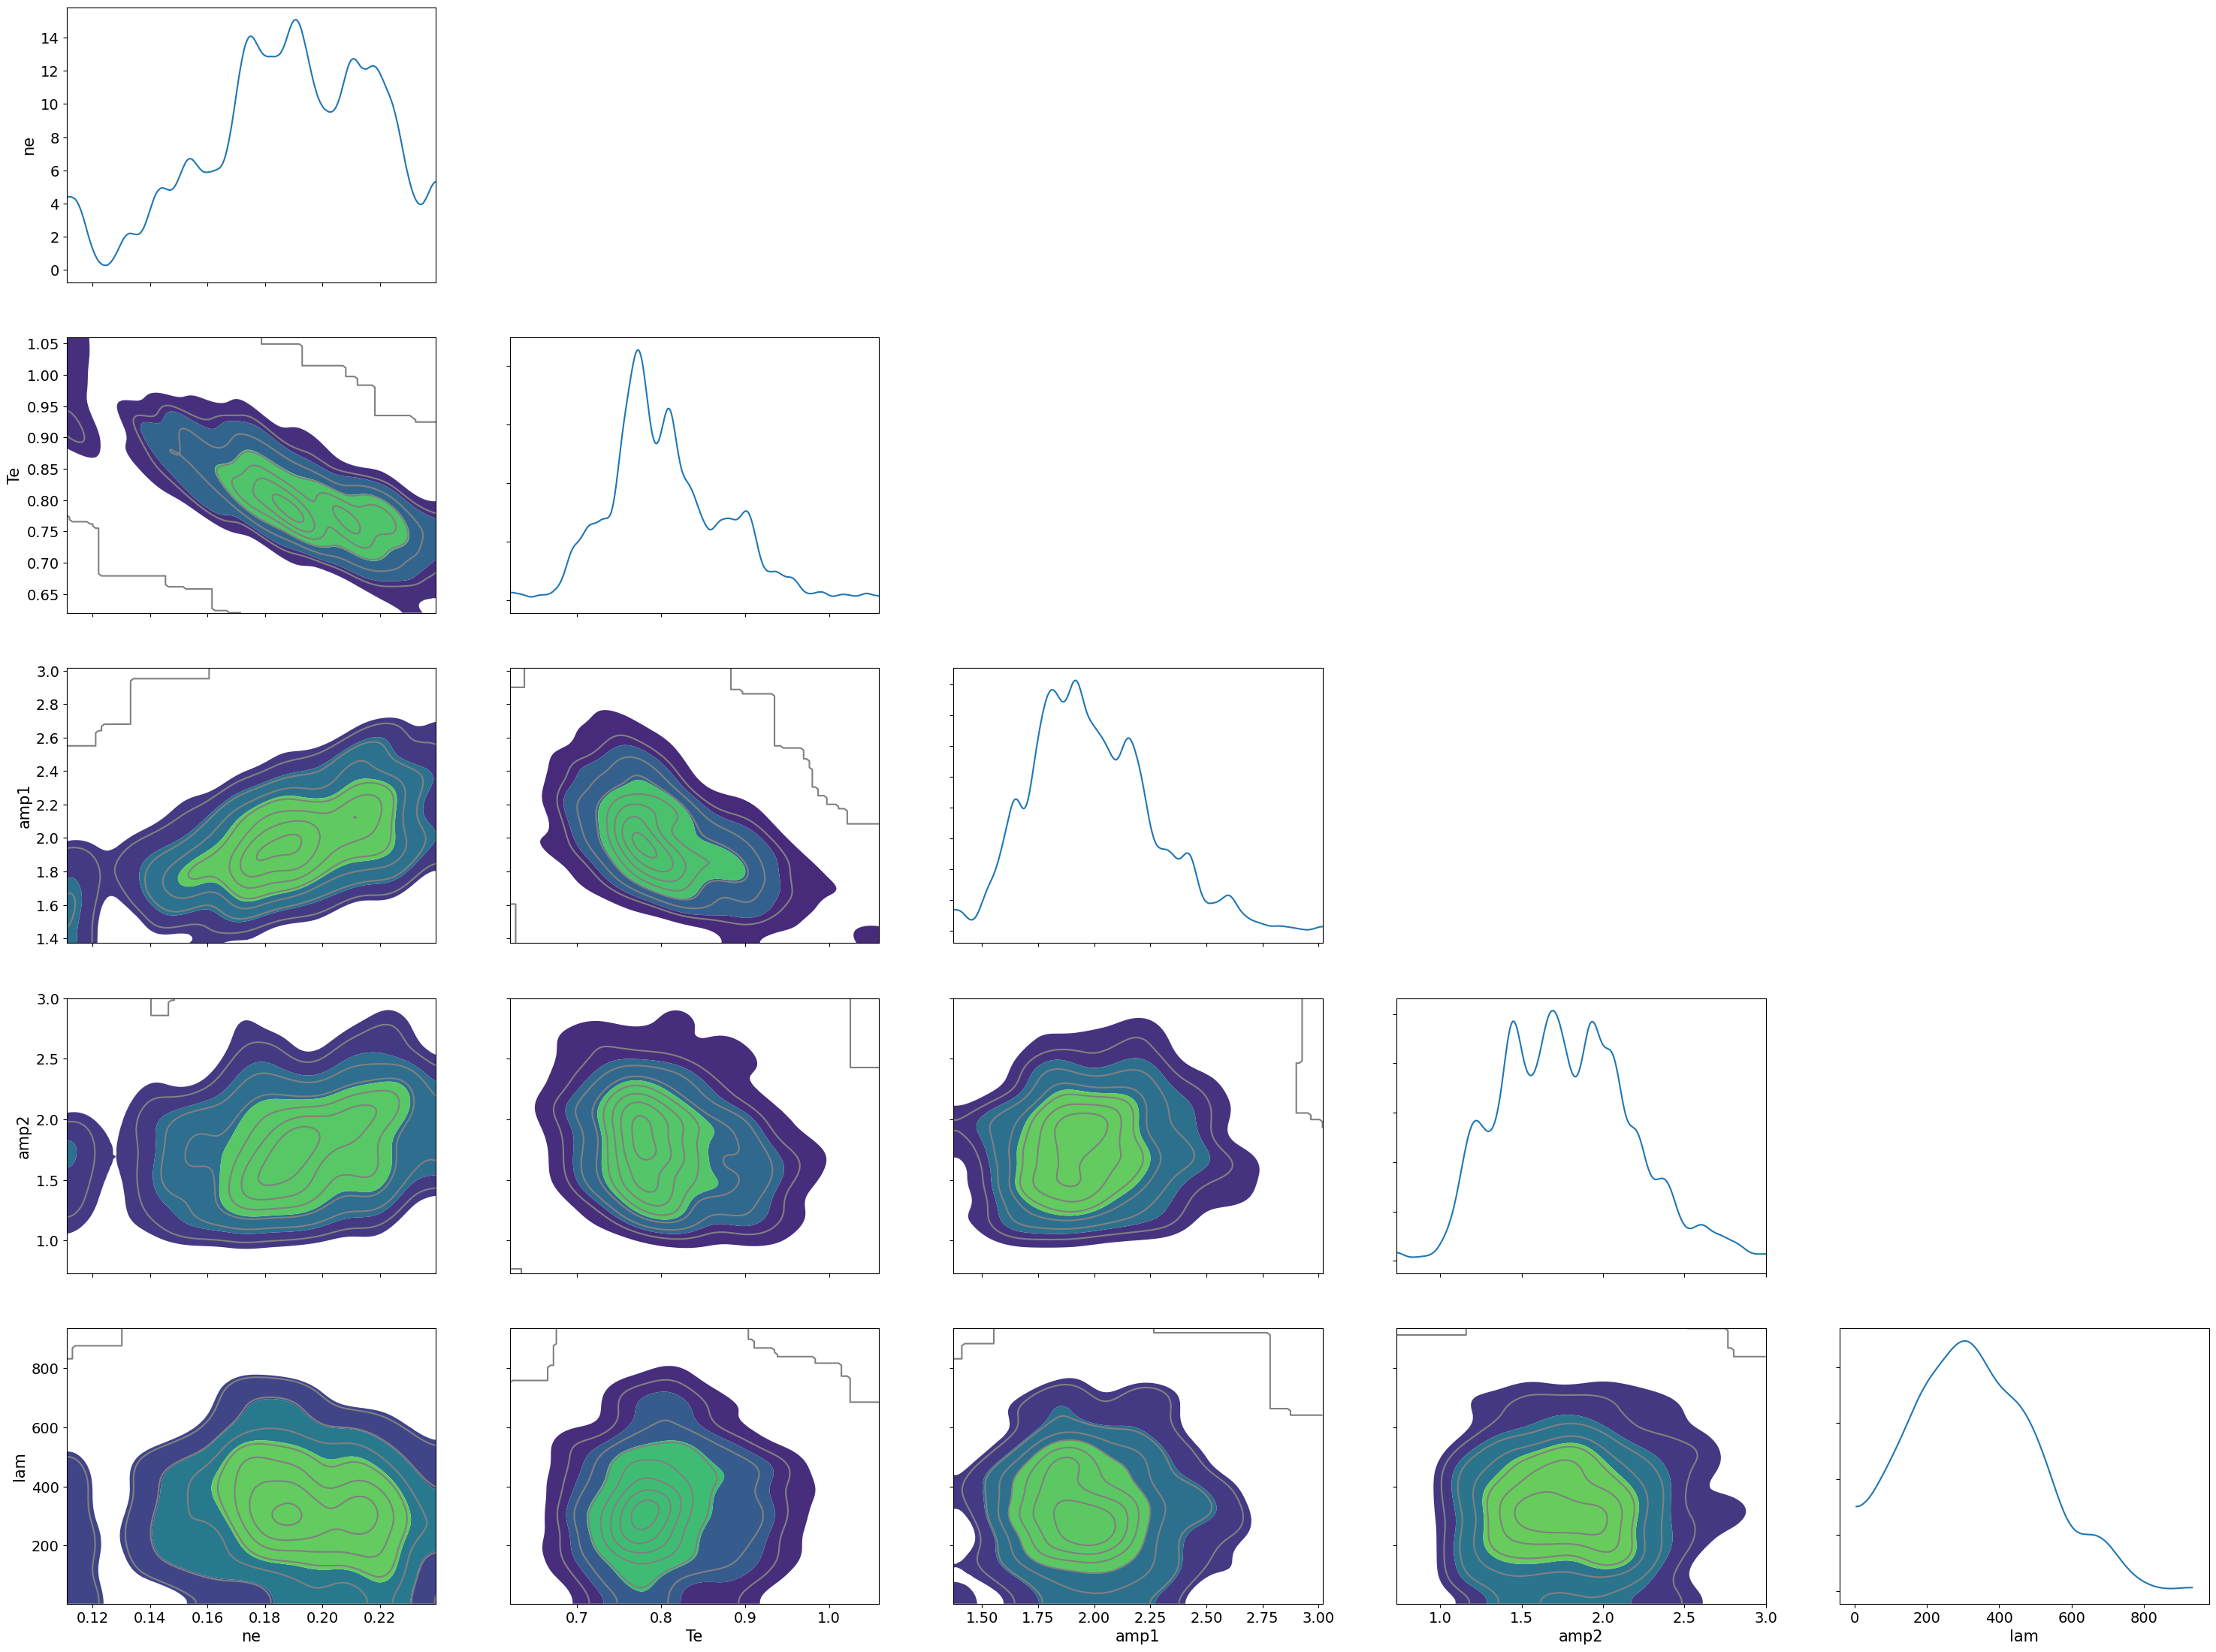

In [8]:
# plot kde's of posterior distribution
az.plot_pair(trace, kind="kde", marginals=True)
plt.savefig("pair_plot_kde.png")
plt.show()